In [1]:
# EXPORT
# --- Must haves ---
import os, sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.cuda as cuda
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from copy import deepcopy

from surrogates4sims.mantaflowDatasets import MantaFlowDataset, getSingleSim, createMantaFlowTrainTest
""
from surrogates4sims.utils import create_opt, create_one_cycle, find_lr, printNumModelParams, \
                                    rmse, writeMessage, plotSampleWprediction, plotSampleWpredictionByChannel, \
                                    plotSample, curl, jacobian, stream2uv, create_movie, convertSimToImage

from surrogates4sims.models import Generator, Encoder, AE_no_P, AE_xhat_z, AE_xhat_zV2

from surrogates4sims.train import trainEpoch, validEpoch

import numpy as np
from tqdm import tqdm
from copy import deepcopy

In [2]:
# data 
eval_only=False
DEBUG = False
# model name, for tensorboard recording and checkpointing purposes.
versionName = "end_to_end_plateau_train"

# GPU Numbers to use. Comma seprate them for multi-GPUs.
gpu_ids = "1,3"
versionName = versionName + '_GPUs{}'.format(gpu_ids.replace(',',''))
# path to load model weights.
pretrained_path = None

# rate at which to record metrics. (number of batches to average over when recording metrics, e.g. "every 5 batches")
tensorboard_rate = 5

# number of epochs to train. This is defined here so we can use the OneCycle LR Scheduler.
epochs = 1000

# Data Directory
dataDirec = '/data/mantaFlowSim/data/smoke_pos21_size5_f200/v'
reverseXY = False 

# checkpoint directory
cps = 'cps'
tensorboard_direc = "tb"

findLRs = False  

# hyper-params
seed = 1234
np.random.seed(seed)
testSplit = .1
bz = 20
numSamplesToKeep = np.infty #if not debugging
latentDim = 16
window_size = 10 # to-do: have an increasing window size as training proceeds?
filters = 128
num_conv = 4 # breaks when less than 2
simLen = 200
stack = True
simVizIndex = 0 # sim in the test set to visualize
createStreamFcn = False
doJacobian = True
repeat = 0
skip_connection = False
patience = 2
if DEBUG:
    epochs = 10000
    numSamplesToKeep = bz
    
versionName = versionName + '_latentDim{}_window_size{}_filters{}_bz{}_numConv{}_stream{}_jacobian{}_epochs{}_stack{}'.format(latentDim,window_size,filters,bz,num_conv,createStreamFcn,doJacobian,epochs,stack)
versionName

'end_to_end_plateau_train_GPUs13_latentDim16_window_size10_filters128_bz20_numConv4_streamFalse_jacobianTrue_epochs1000_stackTrue'

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

trainData, testData = createMantaFlowTrainTest(dataDirec,simLen,testSplit,seed)
print((len(trainData),len(testData)))

Using device: cuda
(19000, 2000)


In [4]:
class MantaFlowDataset(Dataset):
    def __init__(self, 
                 dataDirec='/data/mantaFlowSim/data/smoke_pos21_size5_f200/v',
                 numToKeep=np.infty,transform=None, reverseXY=False, preprocess=True, AE=False,
                 w = 1, simLen = 200): 
        if type(dataDirec) == list:
            self.files = dataDirec
        else:
            self.files = glob(os.path.join(dataDirec,'*.npz'))
        self.dataDirec = dataDirec
        self.numToKeep = numToKeep
        self.transform = transform
        self.reverseXY = reverseXY
        self.AE = AE
        self.w = w
        self.simLen = simLen
        self.data = []
 
        if numToKeep < len(self.files):
            self.files = self.files[:numToKeep]
        for f in tqdm(self.files):
            X,y = self.loadfile(f)
            
            if preprocess:
                X,y = self.preprocessFcn(X,y)
                
            if reverseXY:
                self.data.append((y,X))
            else:
                self.data.append((X,y))

    def loadfile(self,fn):
        A = np.load(fn)
        X = A['x'].astype('float32')
        X = np.rollaxis(X,-1)
        y = A['y'].astype('float32')
        return X,y

    def preprocessFcn(self,X,y):
        x_range = 11.953
        X /= x_range
        y_range = [[0.2, 0.8], [0.04, 0.12], [0.0, 199.0]]
        for i, ri in enumerate(y_range):
            y[i] = (y[i]-ri[0]) / (ri[1]-ri[0]) * 2 - 1
        return X,y
    
    def __len__(self):
        return len(self.data)

    def plot(self,idx,savefig=False):
        X, label  = self.data[idx]
        if self.reverseXY:
            X = label
            
        plt.figure(figsize=(20,10))
        
        plt.subplot(211)
        fn = self.files[idx].replace('.npz','')
        title = '{} channel 0'.format(fn)
        plt.title(title)
        plt.imshow(X[0][::-1])
        plt.colorbar()
        
        plt.subplot(212)
        title = '{} channel 1'.format(fn)
        plt.title(title)
        plt.imshow(X[1][::-1])
        plt.colorbar()
        
        if savefig:
            title = title.replace(' ','_') + '.png'
            plt.savefig(title, dpi=300)
            plt.close()
        else:
            plt.show()
    
    def __getitem__(self, idx):
        q = idx // self.simLen
        r_idx = np.random.randint(0,self.simLen-self.w)
        x = self.data[q*simLen + r_idx : q*simLen + r_idx + 1]
        y = self.data[q*simLen + r_idx + 1 : q*simLen + r_idx + 1 + self.w]
        # to unpack this data into X (image) and p (cfg settings) arrays, use the following code
        U_x, p_x = zip(*x)
        U_y, p_y = zip(*y)
        return np.array(U_x), np.array(U_y), np.array(p_x), np.array(p_y)

In [5]:
# datasets may be smaller because: numSamplesToKeep 
testDataset = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False,
                               w=window_size, simLen=simLen)
trainDataset = MantaFlowDataset(trainData, reverseXY=reverseXY,numToKeep=numSamplesToKeep, AE=False,
                                w=window_size, simLen=simLen)
len(trainDataset), len(testDataset)


100%|██████████| 19000/19000 [00:32<00:00, 575.82it/s]


(19000, 2000)

In [6]:
trainDataLoader = DataLoader(dataset=trainDataset, batch_size=bz, shuffle=True, drop_last=True, pin_memory = True)
testDataLoader = DataLoader(dataset=testDataset, batch_size=bz, pin_memory=True)
# only use the first frame of each simulation as the input (U_x) for the full simulation test dataloader, 
# the next 199 frames are stored in the targets (U_y).
# added this on 10/27/2020
testDataset_w_simLen = MantaFlowDataset(testData, reverseXY=reverseXY, numToKeep=numSamplesToKeep, AE=False,
                               w=simLen-1, simLen=simLen)
first_frame_testDataset = torch.utils.data.Subset(testDataset_w_simLen, range(0, len(testDataset), simLen))
simulation_testDataLoader = DataLoader(dataset= first_frame_testDataset, batch_size=2)

U_x, U_y, p_x, p_y = next(iter(trainDataLoader))
print(U_x.shape, p_x.shape)
U_x = U_x.squeeze(1) # squeeze away the window dimension for inputs, not targets (e.g., not U_y)
p_x = p_x.squeeze(1) # squeeze away the window dimension for inputs, not targets (e.g., not U_y)
U_x.shape, U_y.shape, p_x.shape, p_y.shape

torch.Size([20, 1, 2, 128, 96]) torch.Size([20, 1, 3])


(torch.Size([20, 2, 128, 96]),
 torch.Size([20, 10, 2, 128, 96]),
 torch.Size([20, 3]),
 torch.Size([20, 10, 3]))

In [7]:
# confirm that timestep number in p_y is contiguous within a window
((p_y[:,:,2]+1)/2 * 199)[:10]

tensor([[ 65.0000,  66.0000,  67.0000,  68.0000,  69.0000,  70.0000,  71.0000,
          72.0000,  73.0000,  74.0000],
        [151.0000, 152.0000, 153.0000, 154.0000, 155.0000, 156.0000, 157.0000,
         158.0000, 159.0000, 160.0000],
        [185.0000, 186.0000, 187.0000, 188.0000, 189.0000, 190.0000, 191.0000,
         192.0000, 193.0000, 194.0000],
        [137.0000, 138.0000, 139.0000, 140.0000, 141.0000, 142.0000, 143.0000,
         144.0000, 145.0000, 146.0000],
        [173.0000, 174.0000, 175.0000, 176.0000, 177.0000, 178.0000, 179.0000,
         180.0000, 181.0000, 182.0000],
        [153.0000, 154.0000, 155.0000, 156.0000, 157.0000, 158.0000, 159.0000,
         160.0000, 161.0000, 162.0000],
        [ 16.0000,  17.0000,  18.0000,  19.0000,  20.0000,  21.0000,  22.0000,
          23.0000,  24.0000,  25.0000],
        [ 73.0000,  74.0000,  75.0000,  76.0000,  77.0000,  78.0000,  79.0000,
          80.0000,  81.0000,  82.0000],
        [131.0000, 132.0000, 133.0000, 134.0000,

In [8]:
# we are now subsetting this data to only include the first frame in each sim, p_y and U_y include next 199 frames
print(len(simulation_testDataLoader), len(simulation_testDataLoader.dataset))
for batch in simulation_testDataLoader:
    test_U_x, test_U_y, test_p_x, test_p_y = batch
    assert (test_p_x[0,:,2]+1)/2 * 199 == 0
    assert (test_p_x[1,:,2]+1)/2 * 199 == 0

print(((test_p_y[0,:,2]+1)/2 * 199))
test_U_x.shape, test_U_y.shape, test_p_x.shape, test_p_y.shape

5 10
tensor([  1.0000,   2.0000,   3.0000,   4.0000,   5.0000,   6.0000,   7.0000,
          8.0000,   9.0000,  10.0000,  11.0000,  12.0000,  13.0000,  14.0000,
         15.0000,  16.0000,  17.0000,  18.0000,  19.0000,  20.0000,  21.0000,
         22.0000,  23.0000,  24.0000,  25.0000,  26.0000,  27.0000,  28.0000,
         29.0000,  30.0000,  31.0000,  32.0000,  33.0000,  34.0000,  35.0000,
         36.0000,  37.0000,  38.0000,  39.0000,  40.0000,  41.0000,  42.0000,
         43.0000,  44.0000,  45.0000,  46.0000,  47.0000,  48.0000,  49.0000,
         50.0000,  51.0000,  52.0000,  53.0000,  54.0000,  55.0000,  56.0000,
         57.0000,  58.0000,  59.0000,  60.0000,  61.0000,  62.0000,  63.0000,
         64.0000,  65.0000,  66.0000,  67.0000,  68.0000,  69.0000,  70.0000,
         71.0000,  72.0000,  73.0000,  74.0000,  75.0000,  76.0000,  77.0000,
         78.0000,  79.0000,  80.0000,  81.0000,  82.0000,  83.0000,  84.0000,
         85.0000,  86.0000,  87.0000,  88.0000,  89.0000,  

(torch.Size([2, 1, 2, 128, 96]),
 torch.Size([2, 199, 2, 128, 96]),
 torch.Size([2, 1, 3]),
 torch.Size([2, 199, 3]))

In [9]:
# Encoder 

AE_model = AE_xhat_zV2(U_x, filters, latentDim, num_conv, repeat, 
                 skip_connection, stack, conv_k=3, last_k=3, 
                 act=nn.LeakyReLU(), return_z=True, stream=createStreamFcn, device='cpu')

'''
if len(gpu_ids.split(',')) > 1:
    AE_model = nn.DataParallel(AE_model)
    
'''
Xhat,z = AE_model(U_x)
Xhat.shape, z.shape

/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


[128, 8, 6]


(torch.Size([20, 2, 128, 96]), torch.Size([20, 16]))

In [10]:
versionName

'end_to_end_plateau_train_GPUs13_latentDim16_window_size10_filters128_bz20_numConv4_streamFalse_jacobianTrue_epochs1000_stackTrue'

In [11]:
AE_model.load_state_dict(torch.load(os.path.join('/home/widemann1/surrogates4sims/cps',
'plateau_train_GPUs2_latentDim16_filters128_bz16_numConv4_streamFalse_jacobianFalse_epochs1000_stackTrue_lr0.0001')))
# for 512 dim ? :
#plateau_train_GPUs0_latentDim512_filters128_bz16_numConv4_streamFalse_jacobianFalse_epochs10000_stackTrue_lr0.0001

<All keys matched successfully>

In [12]:
# LIN Model
class MLP(nn.Module):
    def __init__(self, X, hiddenLayerSizes = [1024], activation=nn.ELU()):
        super(MLP,self).__init__()
        
        self.activation = activation
        self.inputSize = X.shape[1:]
        self.modules = []
        self.modules.append(nn.Linear(np.prod(self.inputSize),hiddenLayerSizes[0], bias=False))
        self.modules.append(nn.BatchNorm1d(hiddenLayerSizes[0]))
        self.modules.append(self.activation)
        self.modules.append(nn.Dropout(p=0.1))
        for idx,sz in enumerate(hiddenLayerSizes[:-1]):
            self.modules.append(nn.Linear(hiddenLayerSizes[idx],hiddenLayerSizes[idx+1], bias=False))
            self.modules.append(nn.BatchNorm1d(hiddenLayerSizes[0]))
            self.modules.append(self.activation)
            self.modules.append(nn.Dropout(p=0.1))
                               
        self.modules.append(nn.Linear(hiddenLayerSizes[-1],np.prod(self.inputSize)))
        self.layers = nn.Sequential(*self.modules)
                                
        
    def forward(self,x):
        x = self.layers(x)
        return x
    
hiddenLayers = [128,128]
LIN_model = MLP(z, hiddenLayerSizes=hiddenLayers, activation=nn.ELU())
'''
if len(gpu_ids.split(',')) > 1:
    LIN_model = nn.DataParallel(LIN_model)
'''

"\nif len(gpu_ids.split(',')) > 1:\n    LIN_model = nn.DataParallel(LIN_model)\n"

In [13]:
# surrogate class

class Surrogate(nn.Module):
    
    def __init__(self, window,
                 z_size, p_size,
                LIN, encoder, decoder):
        super(Surrogate, self).__init__()
        self.window = window
        self.z_size = z_size # this does not include the size of p
        self.p_size = p_size
        self.c_size = z_size + p_size # this does include the size of p
        self.LIN = LIN
        self.encoder = encoder
        self.decoder = decoder
        
    def encode(self, U):
        
        return self.encoder(U)
        
    def decode(self, encoding):
        
        return self.decoder(encoding)
        
    def predict_next_w_encodings(self, encoding, p_y, window):
        '''
        use the LIN to predict the next w encodings for each 
        encoded U in the batch
        '''
            
        predicted_encodings = []
            
        # given a batch of encodings, advance each encoding window time steps.
        # save the result at each time step
        for i in range(window):
            encoding = self.LIN(encoding) + encoding # use LIN to predict delta in encoding
            # this was encoding[:,:,-self.p_size:] in 09_manta..., why the extra dimension?
            encoding[:,-self.p_size:] = p_y[:, i]
            predicted_encodings.append(encoding)
            
            
        return torch.stack(predicted_encodings)
    
    def forward(self, U, p_x, p_y, window = None):
        
        if window == None:
            window = self.window
        assert p_y.size(1) == window
            
        encoding = self.encode(U)
        encoding[:,-self.p_size:] = p_x # added this on 10/27/2020
        encoding_w = self.predict_next_w_encodings(encoding, p_y, window)
        # want to have this agree with U_y, which is [batch_size, window_size, channels, nx, ny]
        # right now, it's [window_size, batch_size, c_size], so transpose dimensions 0 and 1
        # print(encoding_w.shape)
        U = torch.stack([self.decode(encoding_i) for encoding_i in encoding_w])
        
        return U.transpose(0,1)
    
    
surrogate = Surrogate(window_size, latentDim - 3, 3, LIN_model, AE_model.encoder, AE_model.generator)

In [14]:
# note the important difference here
foo = torch.tensor([[1,1],[2,2],[3,3]])
foo, foo.reshape(2,3), foo.transpose(0,1)

(tensor([[1, 1],
         [2, 2],
         [3, 3]]),
 tensor([[1, 1, 2],
         [2, 3, 3]]),
 tensor([[1, 2, 3],
         [1, 2, 3]]))

In [15]:
encoding = surrogate.encode(U_x)
decoding = surrogate.decode(encoding)
assert surrogate.c_size == latentDim
assert surrogate.p_size == len(p_x[0])
assert encoding.shape[-1] == surrogate.c_size
assert decoding.shape == U_x.shape

In [16]:
U_hat = surrogate.forward(U_x, p_x, p_y)
U_hat.shape, U_y.shape, torch.norm(U_hat-U_y,p=1)/torch.norm(U_y)

(torch.Size([20, 10, 2, 128, 96]),
 torch.Size([20, 10, 2, 128, 96]),
 tensor(972.3260, grad_fn=<DivBackward0>))

In [17]:
del surrogate, encoding, decoding, U_hat

surrogate = Surrogate(window_size, latentDim - 3, 3, LIN_model, AE_model.encoder, AE_model.generator).to(device)

if len(gpu_ids.split(',')) > 1:
    surrogate = nn.DataParallel(surrogate)

In [18]:
surrogate.module.encoder.conv1.weight[-1]

tensor([[[-0.0615,  0.2370,  0.0193],
         [-0.1209, -0.1067,  0.1109],
         [-0.0105,  0.0456, -0.2153]],

        [[-0.0179,  0.2263, -0.1354],
         [ 0.0473, -0.0644, -0.1862],
         [-0.0807,  0.0856,  0.0642]]], device='cuda:0',
       grad_fn=<SelectBackward>)

In [19]:
max_lr = .0001
start_lr = 5*max_lr/10
#opt = create_opt(max_lr,model)
#lr_scheduler = create_one_cycle(opt,max_lr,epochs,trainDataLoader)
opt = torch.optim.Adam(surrogate.parameters(),lr=max_lr,betas=(.5,.999))
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=patience)

In [20]:
def L1_loss(pred, target):
    return torch.mean(torch.abs(pred - target))


def jacobian_loss(pred, target, device='cpu'):
    return L1_loss(
        torch.stack([jacobian(pred_window_i, device) for pred_window_i in pred.transpose(0,1)]), 
        torch.stack([jacobian(target_window_i, device) for target_window_i in target.transpose(0,1)])
        )


def curl_loss(pred, target, device):
    return L1_loss(curl(pred, device), curl(target, device))


L = nn.MSELoss()


def p_loss(pred, target):
    return L(pred[:, -target.shape[1]:], target)


def loss(pred, target, device):
    
    if createStreamFcn:
        pred = stream2uv(pred, device)
        
    L1 = L1_loss(pred, target)
    Lj = 0
    if doJacobian:
        Lj = jacobian_loss(pred, target, device)
        
    return L1 + Lj

In [21]:
def trainEpoch(myDataLoader, tensorboard_writer, model, opt, p_loss, loss,
               metric, lr_scheduler, tensorboard_rate, device,
               tensorboard_recorder_step, total_steps):
    running_loss = 0.0
    running_rmse = 0.0
    total_loss = 0.0
    running_ploss = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Main Training ---
        
        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.squeeze(1).to(device)
        p_x = p_x.squeeze(1).to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
            

        # zero the parameter gradients
        opt.zero_grad()

        U_hat = model(U_x, p_x, p_y)
        pl = 0
        ll = loss(U_hat, U_y, device)
        combined_loss = pl + ll
        combined_loss.backward()
        opt.step()
        
        # loss
        batch_loss = combined_loss.item()
        running_loss += batch_loss
        total_loss += batch_loss
        
        batch_ploss = pl
        running_ploss += batch_ploss

        # --- Metrics Recording ---

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += r

        total_steps += 1

        # tensorboard writes
        if (i % tensorboard_rate == 0):
            tensorboard_recorder_step += 1
            avg_running_loss = running_loss/tensorboard_rate
            avg_running_rmse = running_rmse/tensorboard_rate
            avg_running_ploss = running_ploss/tensorboard_rate
            tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag="p_loss", scalar_value=avg_running_ploss, global_step=tensorboard_recorder_step)
            tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
            # reset running_loss for the next set of batches. (tensorboard_rate number of batches)
            running_loss = 0.0
            running_rmse = 0.0
            running_ploss = 0.0
            tensorboard_writer.flush()

    return total_loss/len(myDataLoader), tensorboard_recorder_step, total_steps

In [22]:
def relative_error_info(model, data, tensorboard_writer, tensorboard_recorder_step, quiet=False):
    U_hats = []
    Us = []
    for i, sampleBatch in enumerate(data, start=1):
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.squeeze(1).to(device)
        p_x = p_x.squeeze(1).to(device)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        with torch.no_grad():
            Us.append(U_y.detach().cpu())
            U_hat = model(U_x, p_x, p_y, window=simLen-1)
            U_hats.append(U_hat.detach().cpu())
            
    Real_U = torch.stack(Us)
    Surr_U = torch.stack(U_hats)
    rel_error = torch.norm(Real_U - Surr_U)/torch.norm(Real_U)
    writeMessage("Relative_Error: {:.4e}".format(rel_error),versionName)
    if not quiet:
        tensorboard_writer.add_scalar(tag="Relative_Error", scalar_value=rel_error,
                                  global_step=tensorboard_recorder_step)

    
    sample_sim = U_hat[0].cpu()
    sample_GT = U_y[0].cpu()
    fig = plt.figure()
    frame_error = torch.norm((sample_GT - sample_sim).view(simLen-1,-1), 
                                 dim=1)/torch.norm(sample_GT.view(simLen-1,-1), dim=1)
    plt.plot(range(1,200),frame_error)
    plt.title("Relative Error over Time for One Test Simulation")
    if not quiet:
        tensorboard_writer.add_figure('test_rel_error_by_frame', fig, global_step=tensorboard_recorder_step,
                                  close=True, walltime=None)
    
    return sample_sim, sample_GT, rel_error

In [23]:
def validEpoch(myDataLoader, tensorboard_writer, model, p_loss, loss, metric,
               device, tensorboard_recorder_step, lr_scheduler):
    running_loss = 0.0
    running_rmse = 0.0
    for i, sampleBatch in enumerate(myDataLoader, start=1):

        # --- Metrics Recording ---

        # gpu
        U_x, U_y, p_x, p_y = sampleBatch
        U_x = U_x.squeeze(1).to(device) # only squeeze away the window dimension (because batch size = 1)
        p_x = p_x.squeeze(1).to(device) # only squeeze away the window dimension (because batch size = 1)
        U_y = U_y.to(device)
        p_y = p_y.to(device)
        
        perc = len(U_x)/len(myDataLoader.dataset)

        # forward, no gradient calculations
        with torch.no_grad():
            U_hat = model(U_x, p_x, p_y, window = simLen-1)

        # loss
        combined_loss = loss(U_hat, U_y, device)
        
        running_loss += perc*(combined_loss.item())

        # metrics
        r = metric(U_hat, U_y)
        running_rmse += perc*r

    avg_running_loss = running_loss
    avg_running_rmse = running_rmse
    tensorboard_writer.add_scalar(tag="Loss", scalar_value=avg_running_loss, global_step=tensorboard_recorder_step)
    tensorboard_writer.add_scalar(tag=metric.__name__, scalar_value=avg_running_rmse, global_step=tensorboard_recorder_step)
    
    _, _, rel_error = relative_error_info(model, simulation_testDataLoader, 
                                          tensorboard_writer, tensorboard_recorder_step)
    tensorboard_writer.flush()
    lr_scheduler.step(rel_error)
    
    return running_loss

In [24]:
try:
    os.mkdir(cps)
except:
    print("checkpoints directory already exists :)")
    
# create a summary writer.
train_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'train'))
test_writer = SummaryWriter(os.path.join(tensorboard_direc, versionName,'valid'))
tensorboard_recorder_step = 0
total_steps = 0

checkpoints directory already exists :)


In [25]:
writeMessage('---------- Started Training ----------', versionName)
bestLoss = np.infty

if not eval_only:
    for epoch in tqdm(range(1, epochs+1)):  # loop over the dataset multiple times

        writeMessage("--- Epoch {0}/{1} ---".format(epoch, epochs), versionName)

        surrogate.train()
        trainLoss, tensorboard_recorder_step, total_steps = trainEpoch(trainDataLoader, 
                                                                       train_writer, surrogate,
                                                                       opt, p_loss, loss,
                                                                       rmse, lr_scheduler, 
                                                                       tensorboard_rate, device,
                                                                       tensorboard_recorder_step, total_steps)

        writeMessage("trainLoss: {:.4e}".format(trainLoss),versionName)
        writeMessage("LR: {:.4e}".format(opt.param_groups[0]['lr']),versionName)
#         if trainLoss < bestLoss:
#             bestLoss = trainLoss
#             writeMessage("Better trainLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
#             torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        surrogate.eval()
        valLoss = validEpoch(testDataLoader, test_writer, surrogate, p_loss, loss, rmse, device,
                             tensorboard_recorder_step, lr_scheduler)
        writeMessage("valLoss: {:.4e}".format(valLoss),versionName)

        # checkpoint progress
        if valLoss < bestLoss:
            bestLoss = valLoss
            writeMessage("Better valLoss: {:.4e}, Saving models...".format(bestLoss),versionName)
            torch.save(surrogate.state_dict(), os.path.join(cps,versionName))

        # record lr change
        train_writer.add_scalar(tag="LR", scalar_value=opt.param_groups[0]['lr'], global_step=total_steps)

        if opt.param_groups[0]['lr'] < 5e-8:
            break
    torch.save(surrogate.state_dict(), os.path.join(cps,versionName+'_final_model'))
    writeMessage('---------- Finished Training ----------', versionName)

  0%|          | 0/1000 [00:00<?, ?it/s]

---------- Started Training ----------
--- Epoch 1/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 2.9175e-02
LR: 1.0000e-04
Relative_Error: 1.3890e+00
valLoss: 1.1812e-01
Better valLoss: 1.1812e-01, Saving models...


  0%|          | 1/1000 [19:08<318:40:53, 1148.40s/it]/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


--- Epoch 2/1000 ---
trainLoss: 2.3977e-02
LR: 1.0000e-04


  0%|          | 2/1000 [38:10<317:49:39, 1146.47s/it]

Relative_Error: 1.1494e+00
valLoss: 1.0482e-01
Better valLoss: 1.0482e-01, Saving models...
--- Epoch 3/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 2.2357e-02
LR: 1.0000e-04
Relative_Error: 1.0906e+00
valLoss: 9.4124e-02
Better valLoss: 9.4124e-02, Saving models...


  0%|          | 3/1000 [57:14<317:20:09, 1145.85s/it]/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


--- Epoch 4/1000 ---
trainLoss: 2.1017e-02
LR: 1.0000e-04


  0%|          | 4/1000 [1:16:19<316:57:49, 1145.65s/it]

Relative_Error: 1.0851e+00
valLoss: 1.0291e-01
--- Epoch 5/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 2.0327e-02
LR: 1.0000e-04


  0%|          | 5/1000 [1:35:22<316:23:23, 1144.73s/it]

Relative_Error: 1.1856e+00
valLoss: 1.0885e-01
--- Epoch 6/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.9384e-02
LR: 1.0000e-04


  1%|          | 6/1000 [1:54:25<315:55:00, 1144.17s/it]

Relative_Error: 1.1680e+00
valLoss: 1.1102e-01
--- Epoch 7/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.8881e-02
LR: 1.0000e-04


  1%|          | 7/1000 [2:13:30<315:43:04, 1144.60s/it]

Relative_Error: 1.2109e+00
valLoss: 1.1364e-01
--- Epoch 8/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.5201e-02
LR: 1.0000e-05


  1%|          | 8/1000 [2:32:37<315:33:56, 1145.20s/it]

Relative_Error: 1.1895e+00
valLoss: 1.1070e-01
--- Epoch 9/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.4723e-02
LR: 1.0000e-05


  1%|          | 9/1000 [2:51:43<315:16:39, 1145.31s/it]

Relative_Error: 1.1866e+00
valLoss: 1.0826e-01
--- Epoch 10/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.4521e-02
LR: 1.0000e-05


  1%|          | 10/1000 [3:10:47<314:51:36, 1144.95s/it]

Relative_Error: 1.1697e+00
valLoss: 1.0683e-01
--- Epoch 11/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.3847e-02
LR: 1.0000e-06


  1%|          | 11/1000 [3:29:50<314:25:22, 1144.51s/it]

Relative_Error: 1.1874e+00
valLoss: 1.0805e-01
--- Epoch 12/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.4037e-02
LR: 1.0000e-06


  1%|          | 12/1000 [3:48:57<314:17:25, 1145.19s/it]

Relative_Error: 1.2275e+00
valLoss: 1.1235e-01
--- Epoch 13/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.3936e-02
LR: 1.0000e-06


  1%|▏         | 13/1000 [4:08:01<313:50:41, 1144.72s/it]

Relative_Error: 1.1997e+00
valLoss: 1.0889e-01
--- Epoch 14/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.3915e-02
LR: 1.0000e-07


  1%|▏         | 14/1000 [4:27:02<313:13:47, 1143.64s/it]

Relative_Error: 1.1997e+00
valLoss: 1.0805e-01
--- Epoch 15/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.4051e-02
LR: 1.0000e-07


  2%|▏         | 15/1000 [4:46:10<313:15:14, 1144.89s/it]

Relative_Error: 1.1947e+00
valLoss: 1.1084e-01
--- Epoch 16/1000 ---


/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


trainLoss: 1.3902e-02
LR: 1.0000e-07


  2%|▏         | 15/1000 [5:05:12<334:02:23, 1220.86s/it]

Relative_Error: 1.2360e+00
valLoss: 1.1034e-01
---------- Finished Training ----------


In [26]:
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec
import matplotlib.animation as manimati
from matplotlib import animation, rc
from IPython.display import Video
def create_1_channel_movie(im,outfile='sim.mp4',title='surrogate            simulation'):
    ti = 0
    u_mx = 255 #np.max(np.abs(Xrgb))
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.title(title)
    #cmap = plt.cm.ocean
    img = ax.imshow(im[0].squeeze(),  vmin=0, vmax=u_mx)
    #plt.show()
    
    # initialization function: plot the background of each frame
    def init():
        img = ax.imshow(im[0].squeeze(),  vmin=0, vmax=u_mx)
        return (fig,)

    # animation function. This is called sequentially
    def animate(i):
        img = ax.imshow(im[i].squeeze(), vmin=0, vmax=u_mx)
        return (fig,)


    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(im), interval=20, blit=True)
    anim.save(outfile, fps=30, extra_args=['-vcodec', 'libx264'])
    
def get_img(X):
    M = 255
    mx = X.max()
    mn = X.min()
    X = (X - mn)/(mx - mn)
    C = (M*X).type(torch.uint8)
    return C

def make_movie(sample_sim, sample_GT, ID = ''):
    # get sample_sim and sample_GT from the relative_error_info function above
    Xrgb = torch.cat([get_img(sample_sim), get_img(sample_GT)], dim=3)[:,0].detach().cpu().numpy()
    Xrgb.shape
    
    video_name = versionName + ID
    
    # to-do: dave says we should flip vertically before making the mp4
    outGif = '{}.mp4'.format(video_name)
    create_1_channel_movie(Xrgb,outfile=outGif)

In [27]:
# load surrogate
surrogate.load_state_dict(torch.load(os.path.join(cps,versionName))), surrogate.eval()

(<All keys matched successfully>,
 DataParallel(
   (module): Surrogate(
     (LIN): MLP(
       (activation): ELU(alpha=1.0)
       (layers): Sequential(
         (0): Linear(in_features=16, out_features=128, bias=False)
         (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (2): ELU(alpha=1.0)
         (3): Dropout(p=0.1, inplace=False)
         (4): Linear(in_features=128, out_features=128, bias=False)
         (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (6): ELU(alpha=1.0)
         (7): Dropout(p=0.1, inplace=False)
         (8): Linear(in_features=128, out_features=16, bias=True)
       )
     )
     (encoder): Encoder(
       (act): LeakyReLU(negative_slope=0.01)
       (conv1): Conv2d(2, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
       (convs): Sequential(
         (0): convBlock(
           (act): LeakyReLU(negative_slope=0.01)
           (convs): Sequential(
      

/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Relative_Error: 1.0906e+00


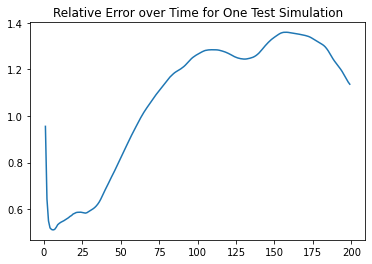

In [28]:
# bring in sample_sim and sample_GT 
sample_sim, sample_GT, rel_error = relative_error_info(surrogate, simulation_testDataLoader, 
                                                       None, None, quiet=True)

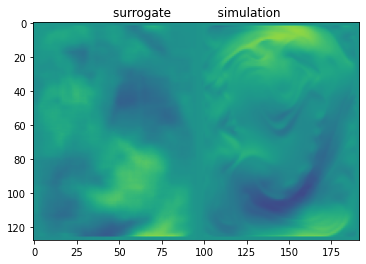

In [29]:
# make movie
make_movie(sample_sim, sample_GT)
Video('{}.mp4'.format(versionName))

/home/bartoldson1/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "


Relative_Error: 9.2834e-01


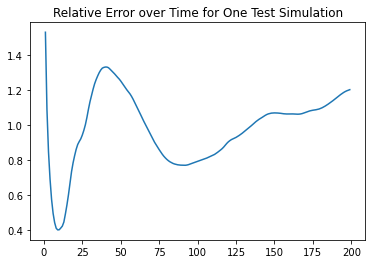

In [30]:
train_w_199 = deepcopy(trainDataset)
train_w_199.w = 199
first_frame_trainDataset = torch.utils.data.Subset(train_w_199, range(4000, 4400, simLen))
simulation_trainDataLoader = DataLoader(dataset= first_frame_trainDataset, batch_size=2)
# bring in sample_sim and sample_GT from train data
sample_sim, sample_GT, rel_error = relative_error_info(surrogate, simulation_trainDataLoader, 
                                                       None, None, quiet=True)

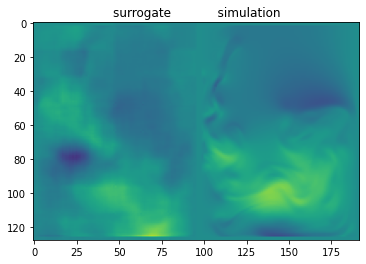

In [31]:
make_movie(sample_sim, sample_GT, ID='_train')
Video('{}.mp4'.format(versionName+'_train'))

In [18]:
versionName

'end_to_end_plateau_train_GPUs13_latentDim16_window_size10_filters128_bz20_numConv4_streamFalse_jacobianTrue_epochs1000_stackTrue'